In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# Importing Depenencies

In [0]:
import numpy as np
import math, cv2, os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Activation, Dense, Conv2D, Reshape, concatenate, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from IPython.display import clear_output
%matplotlib inline
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from random import randint
from sklearn.utils import shuffle
import tensorflow as tf

# Importing Dataset and Visualisation 

In [0]:
train_dataset_path = "/content/drive/My Drive/blood-cells/dataset2-master/dataset2-master/images/TRAIN"
test_dataset_path = "/content/drive/My Drive/blood-cells/dataset2-master/dataset2-master/images/TEST"
pred_dataset_path = "/content/drive/My Drive/blood-cells/dataset2-master/dataset2-master/images/TEST_SIMPLE"

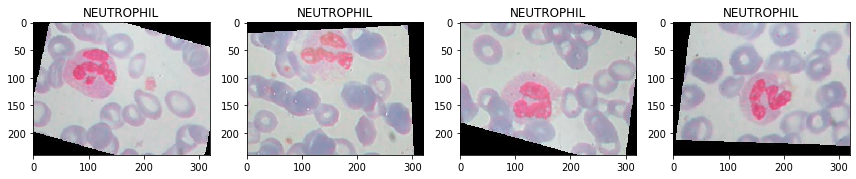

In [27]:
plt.figure(figsize = (12,12))
for i in range(4):
    plt.subplot(1, 4, i+1)
    path = os.listdir(train_dataset_path + '/NEUTROPHIL')[i]
    img = cv2.imread(train_dataset_path + '/NEUTROPHIL' + '/' + path)
    plt.imshow(img)
    plt.title('NEUTROPHIL')
    plt.tight_layout()
plt.show()

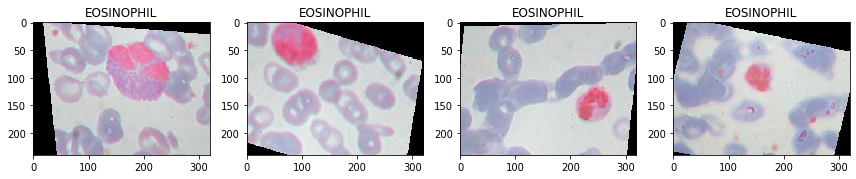

In [28]:
plt.figure(figsize = (12,12))
for i in range(4):
    plt.subplot(1, 4, i+1)
    path = os.listdir(train_dataset_path + '/EOSINOPHIL')[i]
    img = cv2.imread(train_dataset_path + '/EOSINOPHIL' + '/' + path)
    plt.imshow(img)
    plt.title('EOSINOPHIL')
    plt.tight_layout()
plt.show()

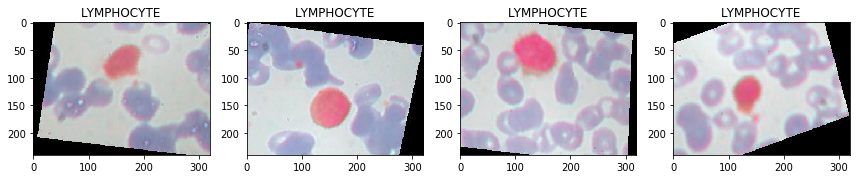

In [29]:
plt.figure(figsize = (12,12))
for i in range(4):
    plt.subplot(1, 4, i+1)
    path = os.listdir(train_dataset_path + '/LYMPHOCYTE')[i]
    img = cv2.imread(train_dataset_path + '/LYMPHOCYTE' + '/' + path)
    plt.imshow(img)
    plt.title('LYMPHOCYTE')
    plt.tight_layout()
plt.show()

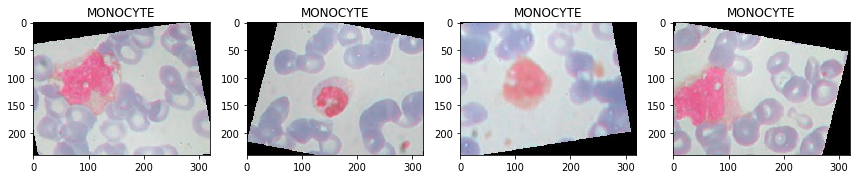

In [30]:
plt.figure(figsize = (12,12))
for i in range(4):
    plt.subplot(1, 4, i+1)
    path = os.listdir(train_dataset_path + '/MONOCYTE')[i]
    img = cv2.imread(train_dataset_path + '/MONOCYTE' + '/' + path)
    plt.imshow(img)
    plt.title('MONOCYTE')
    plt.tight_layout()
plt.show()

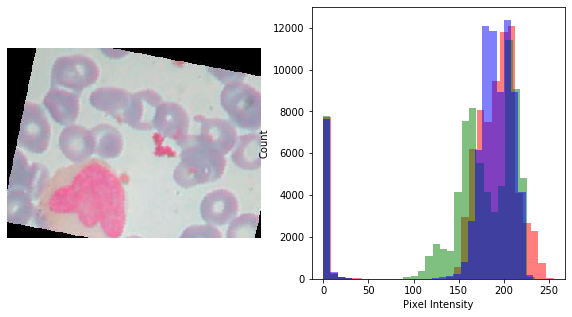

In [31]:
 """
Plot histogram of RGB Pixel Intensities
"""
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
path = os.listdir(train_dataset_path + '/MONOCYTE')[500]
img = cv2.imread(train_dataset_path + '/MONOCYTE' + '/' + path)
plt.imshow(img)
plt.axis('off')
histo = plt.subplot(1,2,2)
histo.set_ylabel('Count')
histo.set_xlabel('Pixel Intensity')
n_bins = 30
plt.hist(img[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
plt.hist(img[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
plt.hist(img[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);

The dataset is already augmented and balanced with each class having ~3000 samples

# Training

In [0]:
IMG_SIZE      = 128
data_list     = os.listdir(train_dataset_path)
NUM_CLASSES   = len(data_list)
BATCH_SIZE    = 32  
EPOCHS        = 25
CATEGORIES    = ['EOSINOPHIL','LYMPHOCYTE','MONOCYTE','NEUTROPHIL']

In [33]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
pred_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dataset_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=None,
        class_mode="categorical")

test_generator = test_datagen.flow_from_directory(
        test_dataset_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=None,
        class_mode="categorical")

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [0]:
''' Helper Functions '''

def lr_decay(epoch):
  return 0.01 * math.pow(0.666, epoch)

callback_learning_rate = LearningRateScheduler(lr_decay, verbose=True)

callback_is_nan = tf.keras.callbacks.TerminateOnNaN()

class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

## Model

In [0]:
bnmomemtum=0.85

def block(x, squeeze, expand):
  y  = Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
  y  = BatchNormalization(momentum=bnmomemtum)(y)
  y1 = Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
  y1 = BatchNormalization(momentum=bnmomemtum)(y1)
  y3 = Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
  y3 = BatchNormalization(momentum=bnmomemtum)(y3)
  return concatenate([y1, y3])

def block_module(squeeze, expand):
  return lambda x: block(x, squeeze, expand)

In [0]:
x = Input(shape=[IMG_SIZE, IMG_SIZE, 3])
y = BatchNormalization(center=True, scale=False)(x)
y = Activation('relu')(y)
y = Conv2D(kernel_size=5, filters=12, padding='same', use_bias=True, activation='relu')(x)
y = BatchNormalization(momentum=bnmomemtum)(y)

y = block_module(12, 24)(y)
y = MaxPooling2D(pool_size=2)(y)

y = block_module(24, 48)(y)
y = MaxPooling2D(pool_size=2)(y)

y = block_module(32, 64)(y)
y = MaxPooling2D(pool_size=2)(y)

y = block_module(24, 48)(y)
y = MaxPooling2D(pool_size=2)(y)

y = block_module(18, 36)(y)
y = MaxPooling2D(pool_size=2)(y)

y = block_module(12, 24)(y)

y = GlobalAveragePooling2D()(y)
y = Dense(NUM_CLASSES, activation='sigmoid')(y)
model = Model(x, y)
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [37]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 128, 128, 12) 912         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 128, 128, 12) 48          conv2d_21[0][0]                  
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 128, 128, 12) 156         batch_normalization_24[0][0]     
____________________________________________________________________________________________

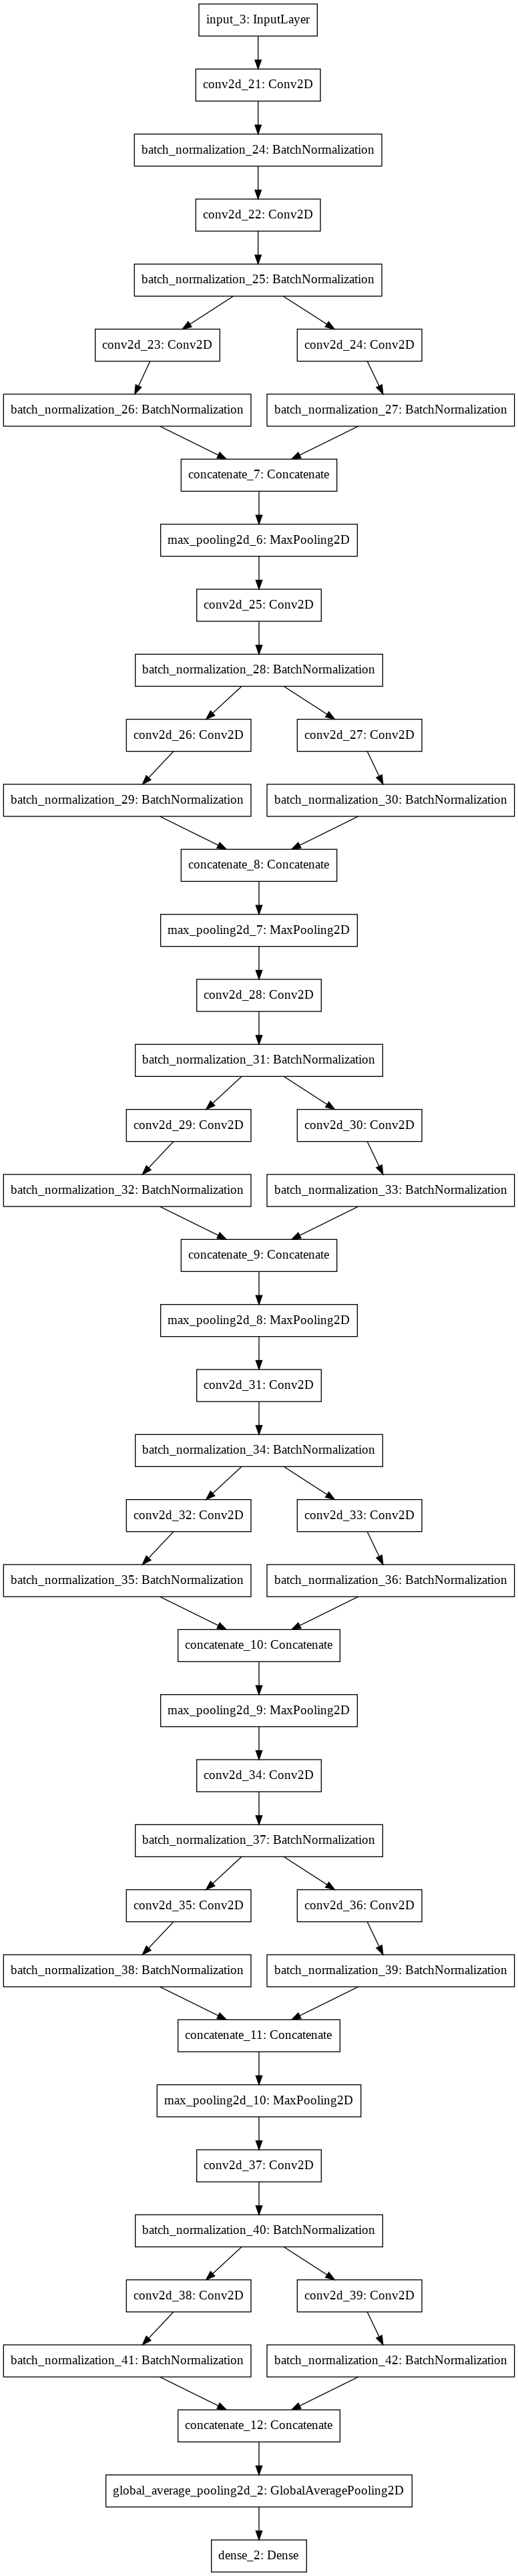

In [38]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

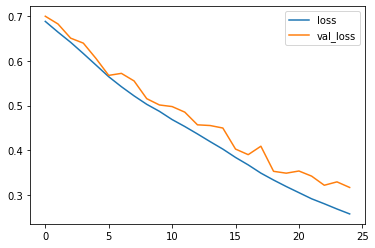

In [39]:
STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size 
STEP_SIZE_VALID=test_generator.n // test_generator.batch_size
history = model.fit_generator(
      train_generator,
      steps_per_epoch=STEP_SIZE_TRAIN, 
      epochs=EPOCHS,
      validation_data=test_generator,
      validation_steps=STEP_SIZE_VALID,
      callbacks=[plot_losses, callback_is_nan]) # callback_learning_rate,

In [40]:
accuracy = history.history['acc']
loss = history.history['loss']
val_accuracy = history.history['val_acc']
val_loss = history.history['val_loss']

print(f'Training Accuracy: {np.max(accuracy)}')
print(f'Training Loss: {np.min(loss)}')
print(f'Validation Accuracy: {np.max(val_accuracy)}')
print(f'Validation Loss: {np.min(val_loss)}')

Training Accuracy: 0.9342569269401301
Training Loss: 0.257665105811895
Validation Accuracy: 0.8883910384537489
Validation Loss: 0.31681572304480915


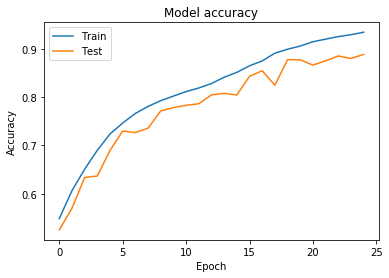

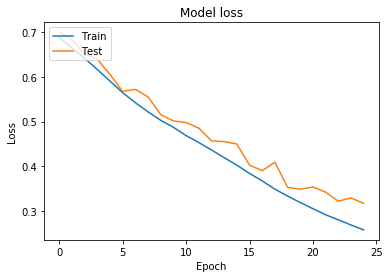

In [41]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Testing

In [42]:
def get_images(directory):
    Images = []
    for categories in CATEGORIES:
        all_image_paths=os.listdir(pred_dataset_path+'/'+categories)
        for image_file in all_image_paths:
            image=cv2.imread(directory+'/'+categories+'/'+image_file)
            image=cv2.resize(image,(IMG_SIZE, IMG_SIZE))
            Images.append(image)

    return shuffle(Images,random_state=81732)

pred_generator = pred_datagen.flow_from_directory(
        pred_dataset_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=None,
        class_mode="categorical")

Found 71 images belonging to 4 classes.


In [43]:
score = model.evaluate_generator(pred_generator, verbose=0)
print('\nTest Accuracy:', score[1],'\n')


Test Accuracy: 0.9225352087490996 

